In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [55]:
data = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", low_memory = False);

In [56]:
columns_to_drop = ['id', 'member_id', 'emp_title']
data = data.drop(columns_to_drop, axis = 1)

In [57]:
def initial_model(df, columns, columns_to_encode, columns_to_normalize):
    min_max_scaler = preprocessing.MinMaxScaler()
    new_df = df.copy()
    new_df = new_df[columns]
    new_df = pd.get_dummies(new_df, dummy_na = True, columns = columns_to_encode)
    new_df[columns_to_normalize] = min_max_scaler.fit_transform(new_df[columns_to_normalize])
    return new_df

In [58]:
cols = ['funded_amnt', 'emp_length', 'home_ownership', 'int_rate',
        'annual_inc', 'verification_status', 'dti', 'loan_status', 'revol_util', 'grade']
cols_encode = ['emp_length', 'home_ownership', 'verification_status', 'grade']
cols_normalize = ['funded_amnt', 'annual_inc', 'dti']

new_df = initial_model(data, cols, cols_encode, cols_normalize)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [59]:
def format_revol(val):
    percent = val[:-1]
    return float(percent)/100

new_df['revol_util'] = new_df['revol_util'].map(format_revol, na_action='ignore')

In [60]:
def format_interest(val):
    percent = val[:-1]
    return float(percent)/100

new_df['int_rate'] = new_df['int_rate'].map(format_interest, na_action='ignore')

In [61]:
new_df[new_df['revol_util'].isnull()] = np.mean(new_df['revol_util'])
new_df[new_df['int_rate'].isnull()] = np.mean(new_df['int_rate'])

In [62]:
new_df = new_df[new_df.loan_status != 'Current'];

In [63]:
new_df.groupby('loan_status').size()

loan_status
0.5549454866843405       31
Charged Off           10303
Default                  11
Fully Paid            43787
In Grace Period          96
Late (16-30 days)        49
Late (31-120 days)      177
dtype: int64

In [64]:
new_df['paid'] = 1;
new_df.loc[new_df.loan_status == 'Fully Paid', 'paid'] = 0;
display(new_df.head())

,funded_amnt,int_rate,annual_inc,dti,loan_status,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,...,verification_status_nan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,paid
0,0.276471,0.0699,0.027749,0.373093,Charged Off,0.316,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.411765,0.1239,0.038027,0.300825,Fully Paid,0.290,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0.195588,0.1366,0.023638,0.870468,Charged Off,0.919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,0.252941,0.1366,0.033402,0.645411,Fully Paid,0.594,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
5,0.600735,0.1559,0.030730,0.462366,Fully Paid,0.762,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [65]:
data_train, data_test = train_test_split(new_df, test_size=.5, stratify=new_df.paid, random_state=99);

In [66]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

In [68]:
cols_to_drop_training = ['loan_status', 'paid', 'int_rate']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [69]:
model = LogisticRegressionCV(cv = 5, multi_class='ovr', penalty = 'l2')
model.fit(x_train, y_train);

In [70]:
model.score(x_train, y_train)

0.8062584934072795

In [71]:
model.score(x_test, y_test)

0.806809417122709

In [72]:
predictions = x_train.copy()
predictions['pred'] = model.predict(x_train)
predictions['proba'] = model.predict_proba(x_train)[:, 1]
predictions['true_val'] = y_train

In [73]:
predictions.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,pred,proba,true_val
6459,0.500000,0.037127,0.445861,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.151901,0
44648,0.752941,0.035971,0.354839,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.135841,1
21632,0.088235,0.006148,0.396599,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.248726,0
48888,0.058824,0.016444,0.520130,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.333095,0
16510,0.680147,0.024920,0.515129,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.259245,0


In [74]:
predictions['class'] = 0;
predictions.loc[predictions.proba > 0.39, 'class'] = 1;
display(predictions.head())

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,pred,proba,true_val,class
6459,0.500000,0.037127,0.445861,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.151901,0,0
44648,0.752941,0.035971,0.354839,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.135841,1,0
21632,0.088235,0.006148,0.396599,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.248726,0,0
48888,0.058824,0.016444,0.520130,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.333095,0,0
16510,0.680147,0.024920,0.515129,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.259245,0,0


In [75]:
accuracy_score(y_train, predictions['class'])

0.798545561391266

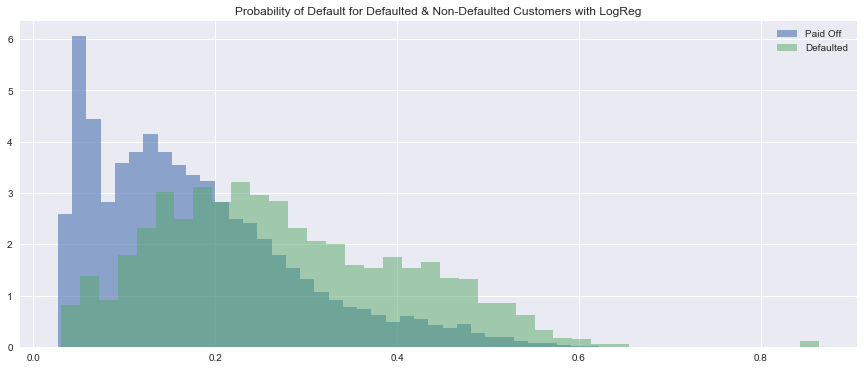

In [76]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);



ax.hist(predictions.loc[predictions.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions.loc[predictions.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with LogReg')
ax.legend(loc='best')

plt.show()

In [77]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [78]:
lda.predict_proba(x_train)

array([[0.86516607, 0.13483393],
       [0.87956393, 0.12043607],
       [0.7490424 , 0.2509576 ],
       ...,
       [0.36975857, 0.63024143],
       [0.93465802, 0.06534198],
       [0.9007097 , 0.0992903 ]])

In [79]:
predictions_lda = x_train.copy()
predictions_lda['pred'] = lda.predict(x_train)
predictions_lda['proba'] = lda.predict_proba(x_train)[:, 1]
predictions_lda['true_val'] = y_train

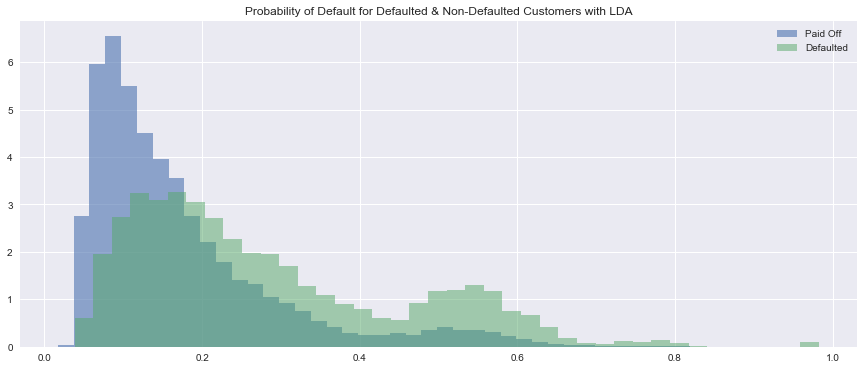

In [80]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_lda.loc[predictions_lda.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_lda.loc[predictions_lda.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with LDA')
ax.legend(loc='best')

plt.show()

In [81]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [82]:
qda.predict_proba(x_train)

array([[1.00000000e+00, 7.58335859e-16],
       [1.00000000e+00, 2.05497678e-19],
       [1.00000000e+00, 4.94482011e-17],
       ...,
       [1.00000000e+00, 1.40514324e-13],
       [1.00000000e+00, 4.23827733e-20],
       [1.00000000e+00, 1.55032450e-18]])

In [83]:
rf = RandomForestClassifier(max_depth = 10, n_estimators = 100)
rf.fit(x_train, y_train);

In [84]:
rf.predict_proba(x_train)

array([[0.84900835, 0.15099165],
       [0.82949401, 0.17050599],
       [0.85316733, 0.14683267],
       ...,
       [0.51319431, 0.48680569],
       [0.91585622, 0.08414378],
       [0.88205853, 0.11794147]])

In [85]:
predictions_rf = x_train.copy()
predictions_rf['pred_train'] = rf.predict(x_train)
predictions_rf['proba_train'] = rf.predict_proba(x_train)[:, 1]
predictions_rf['true_val_train'] = y_train

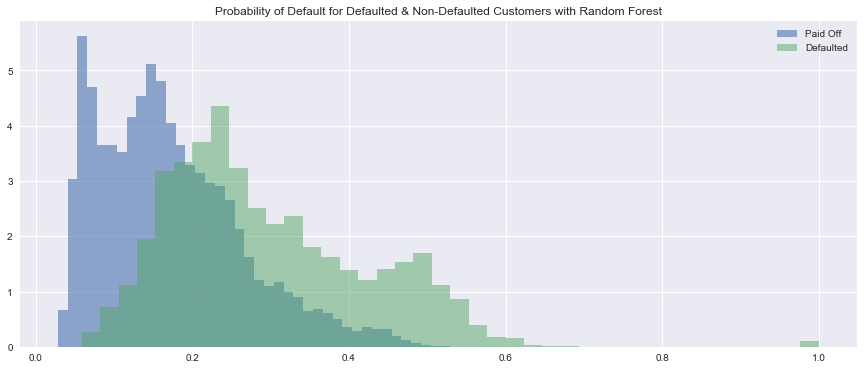

In [86]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_rf.loc[predictions_rf.true_val_train == 0,'proba_train'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_rf.loc[predictions_rf.true_val_train == 1,'proba_train'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with Random Forest')
ax.legend(loc='best')

plt.show()

In [167]:
predictions_test = x_test.copy()
predictions_test['pred_test'] = rf.predict(x_test)
predictions_test['proba_test'] = rf.predict_proba(x_test)[:, 1]
predictions_test['true_val_test'] = y_test
predictions_test['int_rate'] = data_test['int_rate']

In [168]:
predictions_test.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,pred_test,proba_test,true_val_test,int_rate
12518,0.661029,0.029805,0.485871,0.706,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.360422,1,0.1714
46920,0.776471,0.101747,0.272818,0.645,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.231115,0,0.1629
29904,1.000000,0.043474,0.688422,0.696,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0.368178,1,0.1854
16084,0.088235,0.046763,0.328582,0.743,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.120435,0,0.1049
23433,0.058824,0.015930,0.676669,0.662,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.169245,0,0.1366


In [169]:
predictions_test['ROI'] = (1+predictions_test['int_rate'])*(1-predictions_test['proba_test'])

In [170]:
predictions_test.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,grade_D,grade_E,grade_F,grade_G,grade_nan,pred_test,proba_test,true_val_test,int_rate,ROI
12518,0.661029,0.029805,0.485871,0.706,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,0.360422,1,0.1714,0.749202
46920,0.776471,0.101747,0.272818,0.645,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,0.231115,0,0.1629,0.894137
29904,1.000000,0.043474,0.688422,0.696,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,0.368178,1,0.1854,0.748962
16084,0.088235,0.046763,0.328582,0.743,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.120435,0,0.1049,0.971831
23433,0.058824,0.015930,0.676669,0.662,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.169245,0,0.1366,0.944236


In [171]:
#predictions_test = predictions_test.sort_values(by = ["ROI"], axis = 0)

In [172]:
#predictions_test.head()

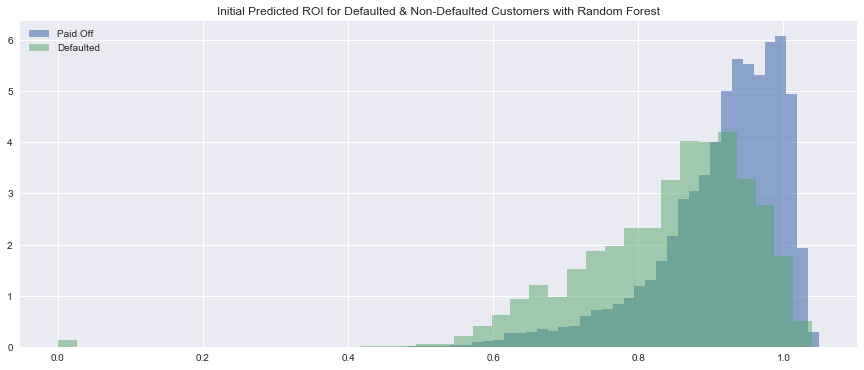

In [176]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_test.loc[predictions_test.true_val_test == 0,'ROI'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_test.loc[predictions_test.true_val_test == 1,'ROI'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Random Forest')
ax.legend(loc='best')

plt.show()